<a href="https://colab.research.google.com/github/BronsonSchultz/487_A5/blob/master/asn5_q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bronson Schultz, 11231230, bcs269
## CMPT 487, A5, q1

# Step 1:  Implement the Histogram of Curvature Scale

Write a function called HoCS that returns a histogram of curvature scale feature vector for a given region.  The inputs to your function should be:

- `B`: a binary image that contains exactly one foreground connected component.
- `min_scale`: The smallest scale (circle radius) at which to calcluate curvature
- `max_scale`: The largest scale (circle radius) at which to calculate curvature
- `increment`: The increment at which intermediate curvatures should be calculated (must be a positive integer)
- `num_bins`: The number of bins in the histogram of curvature for a single scale (must be a positive integer)

Your function should compute a histogram of curvature for each scale, starting at `min_scale` ending at (at most) `max_scale`, and for intermediate scales at increments of `increment`.  For example, if `min_scale`=4 and `max_scale`=20, and `increment`=3, then the function should compute a histogram of curvature for scales 4, 7, 10, 13, 16, and 19.  Each histogram at each scale should have `num_bins` bins.  Curvature must be computed using the normalized area integral invariant method described on Slide 39 of the Topic 9 lecture notes.  

Normalize each histogram at each scale.

To keep things straightforward, your function should only consider the outer perimeter of the input region; ignore the boundaries of holes in the region.

After computing the histogram of curvature at each of the specified scales, all of the histograms should be concatenated into a single one-dimensional array (feature vector) and then returned.

_Implementation hint:  You can calculate the normalized area integral invariant of each pixel efficiently using linear filtering.  You will find the function `skimage.morphology.disk()` function useful for designing the appropriate filter masks._

_Implementation hint:  Most of the heavy lifting here can be done with module functions from `skimage`, `numpy`, and `scipy`.  Many of the functions mentioned in class and in the notes will be useful.  One that we might not have covered, but will be very handy is `numpy.histogram()`.  When you use it, makes sure you specify both the `bins` and `range` optional arguments. Also note that `numpy.histogram()` returns TWO things.  You only need the first one, so make sure you write your function call like this:_

`the_histogram, stuff_you_dont_need = np.histogram(...)`


In [ ]:
import numpy as np
import skimage.morphology as morph
import matplotlib.pyplot as plt
import skimage.segmentation as seg
import skimage.io as io
import skimage.util as util
import pandas as pd

In [ ]:
!git clone https://github.com/BronsonSchultz/487_A5.git

fatal: destination path '487_A5' already exists and is not an empty directory.


In [ ]:
# Code your HoCS function here

def HoCS(B, min_scale, max_scale, increment, num_bins):
  '''
  Computes a histogram of curvature scale for the shape in the binary image B.  
  Boundary fragments due to holes are ignored.
  :param B: A binary image consisting of a single foreground connected component.
  :param min_scale: smallest scale to consider (minimum 1)
  :param max_scale: largest scale to consider (max_scale > min_scale)
  :param increment:  increment on which to compute scales between min_scale and max_scale
  :param num_bins: number of bins for the histogram at each scale
  :return: 1D array of histograms concatenated together in order of increasing scale.
  '''

  B = util.img_as_bool(B)

  # find the boundary of the image and cooridates of the boundary points
  B_border = seg.find_boundaries(B)
  B_border_coords = np.argwhere(B_border > 0)

  hists = []
  for radius in range(min_scale, max_scale+1, increment):
    kps = []

    # take a slice of the image, centered at each point in the boundary
    for point in B_border_coords:
   
      # compute the kp of that slice 
      kp = np.sum(B[point[0]-radius:point[0]+radius+1,point[1]-radius:point[1]+radius+1]) / ((2 * radius + 1) ** 2)
      kps.append(kp)
    hist, edges = np.histogram(kps)
    hists.append(hist)

  return np.array(hists).flatten()


# Step 2: Test your HoCS function.

Run HoCS on `threshimage_0001.png` from the ground truth for assignment 3.  Use `min_scale=5`, `max_scale=25`, `increment=10`, `num_bins=10`.  Plot the resulting feature vector as a bar graph.  Set the y-axis limits to be between 0.0 and 1.0.  You should get a result that matches the sample output in the assignment description.


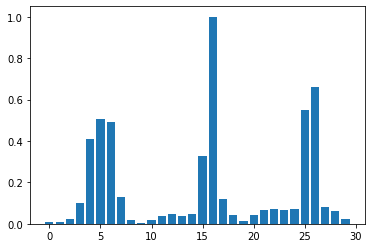

In [ ]:
import skimage.io as io
% matplotlib inline

img = io.imread("/content/487_A5/leaftraining/leaftraining/threshimage_0001.png")
h = HoCS(B=img, min_scale=5, max_scale=25, increment=10, num_bins=10)

plt.bar(np.arange(30), h/max(h))
plt.show()

# Step 3: Calculate training features.

Use your function from Step 1 to compute the HoCS feature for each of the training images.  Use them to train a k-nearest neigbour classifier.  It is up to you to determine the parameters for the HoCS feature such as `min_scale`, `max_scale`, etc. to maximize the classification rate.  This will require some experimentation.  Slides 17-19 of Topic 12 lecture notes will be helpful here.

Also generate the training labels here (a column-array of numbers indicating which descriptors belong to each class, e.g. use values 1,2,3 to indicate class 1, 2, and 3.).

In [ ]:
min_scale = 5
max_scale = 65
increment = 10A
num_bins = 7

In [ ]:
import sklearn.neighbors as neigh
import os as os

# use os.walk() as in previous assignments to process the training images.

X_train = []
for root, dirs, files in os.walk("/content/487_A5/leaftraining/leaftraining/"):
    for filename in sorted(files):
      # ignore files that are not PNG files.
      if filename[-4:] != '.png':
          continue
      # concatenate variable root with filename to get the path to an input file.
      img = io.imread(root+filename)
      X_train.append(HoCS(img,min_scale=min_scale, max_scale=max_scale, increment=increment, num_bins=num_bins))

In [ ]:
# since the filenames are sorted, and there aren't many training images, I just manually create the test labels
y_train = [1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3]

# Step 4: Train the KNN classifier using the feature vectors from the training images.

You have another opportunity here to optimize parameters.  You can experiment with the options for the KNN classifier (in partiuclar n_neighbors) to try to obtain better classification rates.  But you won't really be able to do this until after step 6, so just use default parameters to start with. 

Hint: The steps in this notebook are broken up the way they are so that you can adjust the parameters of training the classifier and then go and perform the classfication without having to re-run the calculation of the features in steps 3 and 5.  You can adjust the parameters here in step 4, and then go and re-run the test set in Step 6 without running step 5 over again -- which is good because step 5 will take a while to run.  Of course you will have to recalculate the features each time you restart PyCharm or the Jupyter Notebook server.

In [ ]:
# Train the KNN classifier
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import mean_squared_error, accuracy_score

knn = KNC(n_neighbors=3, weights='distance', p=1)
knn.fit(X_train, y_train)
pred = knn.predict(X_train)
# sklearn.metrics has a ton of helpful metrics to see how well training and testing goes
print("Training classification MSE = {:.3f}".format(mean_squared_error(y_train, pred)))
print("Training classification accuracy score = {:.3f}".format(accuracy_score(y_train, pred)))

Training classification MSE = 0.000
Training classification accuracy score = 1.000


# Step 5: Calculate the testing features.

Compute the HoCS features for all of the testing images.  Use the same HoCS parameters you did in Step 3.  Also generate class labels for the testing image descriptors.

In [ ]:
# again use os.walk() to process the testing images
X_test = []
y_test = []
for root, dirs, files in os.walk("/content/487_A5/leaftesting/leaftesting/"):
    for filename in sorted(files):
      # ignore files that are not PNG files.
      if filename[-4:] != '.png':
          continue
      # concatenate variable root with filename to get the path to an input file.
      img = io.imread(root+filename)

      # many more testing images, classes are grouped by number
      if int(filename[6:10]) <= 66:
        label = 1
      elif int(filename[6:10]) > 118:
        label = 3
      else:
        label = 2
      
      X_test.append(HoCS(img,min_scale=min_scale, max_scale=max_scale, increment=increment, num_bins=num_bins))
      y_test.append(label)

# Step 6: Classfiy the testing features.

Classify the testing image features.

Determine the classification rate and the confusion matrix by comparing the results of the classifier to the true class labels for each image.  

Print out the filenames of incorrectly classified images.

Print the confusion matrix (you don't have to print the row/column indicies as in the example in the assignment description), just the rows and columns of the matrix itself.

Print the correct classification rate.

It should be very easy to get a classficiation rate more than 90%; with care you should be able to get as much as 95%.

In [ ]:
# Write your code for Step 6 here.
from sklearn.metrics import confusion_matrix 

pred_test = knn.predict(X_test)

In [ ]:
print("Mis-classified images:")
print('image_0056.png')

print('image_0071.png')
print('image_0085.png')
print('image_0092.png')
print('image_0125.png')
print('image_0126.png')
print('image_0133.png')
print('image_0144.png')

print('image_0149.png') 
print('image_0150.png') 
print('image_0151.png') 
print('image_0153.png') 

print('image_0167.png')

Mis-classified images:
image_0056.png
image_0071.png
image_0085.png
image_0092.png
image_0125.png
image_0126.png
image_0133.png
image_0144.png
image_0149.png
image_0150.png
image_0151.png
image_0153.png
image_0167.png


In [ ]:
print("Test classification accuracy rate = {:.3f}".format(accuracy_score(y_test, pred_test)))
print("Test confusion matrix: \n", confusion_matrix(y_test,pred_test))

Test classification accuracy rate = 0.915
Test confusion matrix: 
 [[49  0  1]
 [ 0 22  3]
 [ 1  6 47]]


# Step 7: Reflections

Answer the following questions right here in this block:

- Discuss your HoCS parameters and how you arrived at them.  Why did you choose the scales and number of histogram bins that you did?  Are there other values that work just as well?   Likely you tested other HoCS parameters that resulted in worse performance before finding the ones that worked best -- what were some of them and why do you think the performance was worse?

	_Your answer:_ 
  > I used the example parameters from step two as a starting point, then tried to isolate each one by changing it while leaving the rest the same. Using a `min_scale` < 5 doesn't achieve any better results, because of the small scale. Thinking of a disk with radius = 1, the circle will fill easily (be recognized as flat or convex) by most sections except for very sharp points.

  > increasing `max_scale` allows for a greater range of radii to be used, finding the curvature features of each leaf class will help differentiate the classes, because we have more information about what makes each class unique. I stopped at 65 because after that we have a very large mask that gives a too general description of the leaf regions, decreasing the test accuracy.

  > changing `increment` didn't help for similar reasons, smaller values cause very fine grained calculations that weren't neccessary. For example, if `increment = 1`, the difference between a disk with radius = 1 and and disk with radius = 2 will only be few pixels. if the radius = 1 disk does a good enough job describing the curvature of the region, there's no need to use the bigger disk because it doesn't provide any extra insight. Making `increment` too high has consequences in the other direction, you'll skip over the values that describe the shape quite well.

  > changes in `num_bins` didn't make much difference in the test accuracy. More bins means less values get thrown in the same bin, so the histogram has more detail. Small number of bins will mean more values get thrown in the same bin, losing detail. So, we want the minimum amount of bins, that give the most detail. That seemed to be around the 7 mark. Less than that and the accuracy went down, more than that and the accuracy stayed the same so the extra bins didn't help much.  

- Discuss your choice of KNN classifier parameters and how you arrived at them (think about the same types of questions as in the previous point).

	_Your answer:_
  > The parameters for the KNN classifier were mostly chosen again through trial and error. I found that setting `p = 1` provided a better accuracy rate than the default of 2. p controls the $l_p$ norm to use in calculating the distance between each neighbour. So `p = 1` uses the manhattan distance instead of the euclidean distance. 

  > reducing `n_neighbors` to 3 also increased accuracy. It's hard to visualize the points because we're working in 30+ dimensional feature space but I found going higher than 3 neighbours caused the model to be to general and lower than 3 neighbours made the prediction too specific.

  > setting `weights = 'distance'` puts a penalty on farther away neighbours and gives closer neighbours a stronger vote. This helped accuracy, if there is clustering of some feature(s) for some class, this would help find those clusters and reinforce that they share the same class.  

- Discuss the misclassified images.  Were there any classes that were particularly difficult to distinguish?  Is there anything unusual about any of the misclassified images that would cuase them to be misclassified?  If so, explain

	_Your answer:_

 > most of the images that were mis-identified seem to be the ones with either holes in the leaf, or they are very round for their class. 

 > A small, jagged hole in the image would cause all the $k_p$ values around and in that hole to be very low, especially on the smaller scale radii. These holes would skew the histogram towards a spikier leaf than a round one.

 > The mis-identified class 3 leaves are all ones that are much rounder than others. For example image 0167 is smaller and has shorter tips on the sides and top. Since it's rounder than the other class 3 leaves, it gets classified as class 2.